In [1]:
from google.colab import drive
drive.mount("gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [2]:
%cd "/content/gdrive/My Drive/000_NEW-201910/BOOK/add-python-ai"
!ls -al


/content/gdrive/My Drive/000_NEW-201910/BOOK/add-python-ai
total 2728
-rw------- 1 root root  21294 Jan  6 12:07 01-TensorFlow_Basics.ipynb
-rw------- 1 root root 197496 Jan  6 12:12 02-ML-IMGClassification.ipynb
-rw------- 1 root root  21159 Jan  6 12:15 03-NN-IMGClassification.ipynb
-rw------- 1 root root  12818 Jan  6 12:21 04-CNN-IMGClassification.ipynb
-rw------- 1 root root  10496 Jan  6 12:28 05-RNN-IMGClassification.ipynb
-rw------- 1 root root 120405 Jan  7 12:57 06-KERAS.ipynb
-rw------- 1 root root  35327 Jan  7 14:08 07_NeuralStyleTransfer.ipynb
-rw------- 1 root root  16967 Jan  8 00:58 07-NeuralStyleTransfer.ipynb
-rw------- 1 root root  10832 Jan  6 11:59 4th-python-ai.ipynb
drwx------ 2 root root   4096 Jan  7 13:52 .ipynb_checkpoints
drwx------ 2 root root   4096 Aug 25  2018 KSDS-ADD2018-master
-rw------- 1 root root 230996 Jan  6 12:01 KSDS-ADD2018-master.zip
-rw------- 1 root root 205803 Jan  7 13:25 starry-night.jpg
-rw------- 1 root root 494158 Jan  8 00:49 style_

# 뉴럴 스타일 트랜스퍼(Neural Style Transfer)
- 참조 이미지의 스타일을 타겟 이미지에 적용하는 기술


- 예) 스타일 : 별이 빛나는 밤(Starry Night) <빈센트 반 고흐(Vincent Van Gogh> 그림의 스타일을 튀빙겐(Tubingen) 건물 사진에 적용
<img src="https://www.popit.kr/wp-content/uploads/2018/04/style_transfer_example.png">

- https://www.popit.kr/neural-style-transfer-%EB%94%B0%EB%9D%BC%ED%95%98%EA%B8%B0/


- 목표를 표현한 손실 함수를 정의하고, 손실을 최소화하는 것
- 참조 이미지의 스타일을 적용하면서 원본 이미지의 콘텐츠를 보존하는 것


- 손실 함수
    - content loss
    - style loss

<pre>
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) = content(generated_image))
</pre>


## 변수 초기값 정의


In [3]:
from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = './tubingen.jpg'
# 스타일 이미지 경로
style_reference_image_path = './starry-night.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)


Using TensorFlow backend.


## VGG19 convnet 정의

In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#### VGG19 모델 로딩

In [5]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')





80142336/80134624 [==============================] - 6s 0us/step






모델 로드 완료.


In [6]:
model.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## 손실 함수 정의


In [0]:
# content loss
def content_loss(base, combination):
    return K.sum(K.square(combination - base))



In [0]:
# style loss
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# total loss
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## content loss 및 style loss에 사용할 층 정의



<img src="https://www.popit.kr/wp-content/uploads/2018/04/gatys_algoritm_paper-1024x583.png">


In [10]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

## 그래디언트 구하기


In [11]:
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## L-BFGS 알고리즘을 사용한 경사하강법


콘텐츠 이미지
스타일 이미지


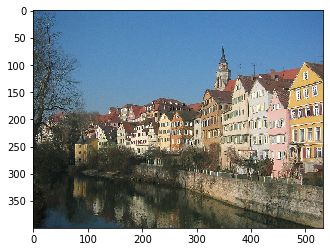

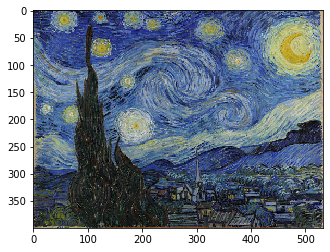

<Figure size 432x288 with 0 Axes>

생성 이미지
반복 횟수: 0
현재 손실 값: 701116500.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 4s


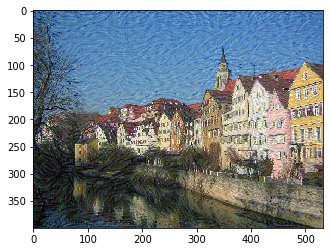

반복 횟수: 1
현재 손실 값: 248781460.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 4s


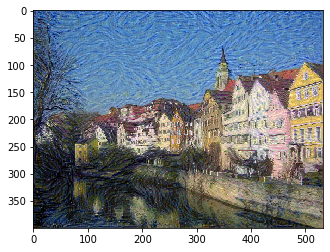

반복 횟수: 2
현재 손실 값: 155305520.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 4s


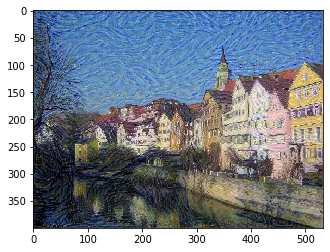

반복 횟수: 3
현재 손실 값: 124208490.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 4s


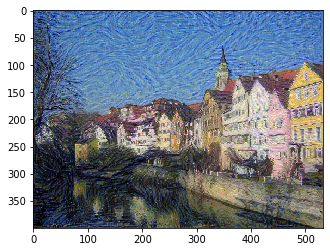

반복 횟수: 4
현재 손실 값: 104797610.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 4s


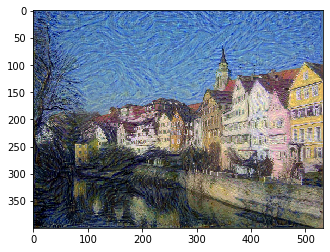

반복 횟수: 5
현재 손실 값: 85414960.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 4s


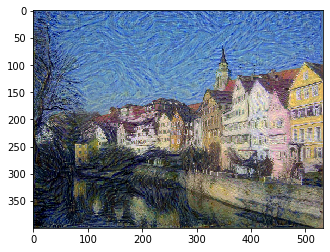

반복 횟수: 6
현재 손실 값: 75586660.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 4s


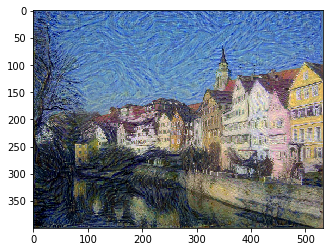

반복 횟수: 7
현재 손실 값: 66841070.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 4s


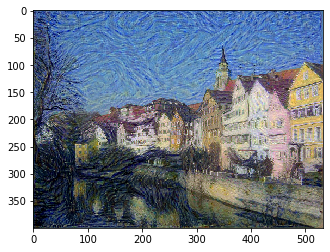

반복 횟수: 8
현재 손실 값: 58888680.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 4s


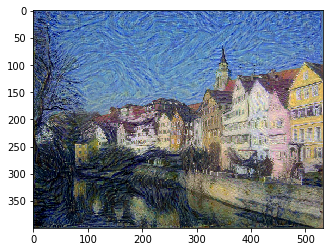

반복 횟수: 9
현재 손실 값: 53351040.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 4s


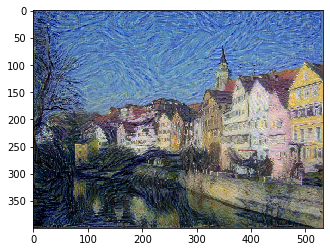

반복 횟수: 10
현재 손실 값: 50638236.0
저장 이미지:  style_transfer_result_at_iteration_10.png
10 번째 반복 완료: 4s


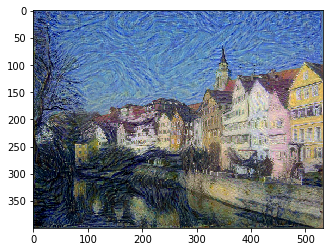

반복 횟수: 11
현재 손실 값: 47679560.0
저장 이미지:  style_transfer_result_at_iteration_11.png
11 번째 반복 완료: 4s


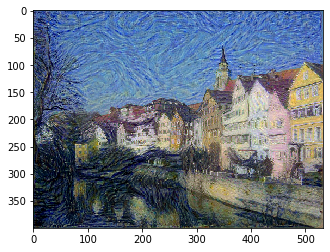

반복 횟수: 12
현재 손실 값: 44762440.0
저장 이미지:  style_transfer_result_at_iteration_12.png
12 번째 반복 완료: 4s


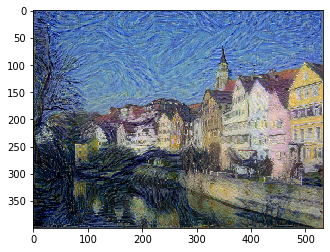

반복 횟수: 13
현재 손실 값: 42980824.0
저장 이미지:  style_transfer_result_at_iteration_13.png
13 번째 반복 완료: 4s


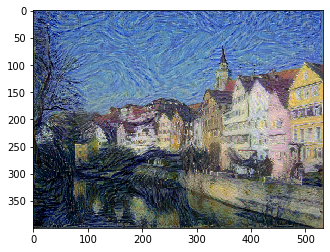

반복 횟수: 14
현재 손실 값: 41365960.0
저장 이미지:  style_transfer_result_at_iteration_14.png
14 번째 반복 완료: 4s


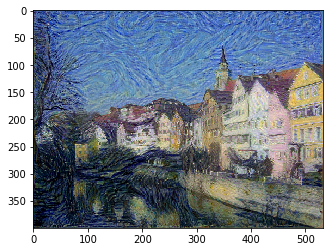

반복 횟수: 15
현재 손실 값: 40056156.0
저장 이미지:  style_transfer_result_at_iteration_15.png
15 번째 반복 완료: 4s


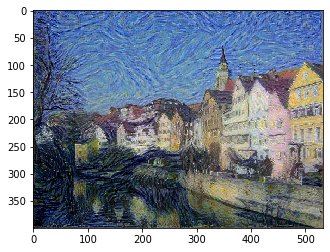

반복 횟수: 16
현재 손실 값: 39011050.0
저장 이미지:  style_transfer_result_at_iteration_16.png
16 번째 반복 완료: 4s


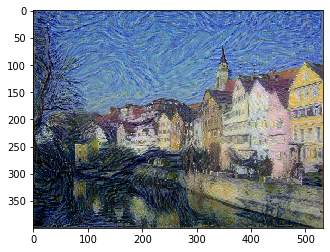

반복 횟수: 17
현재 손실 값: 37669316.0
저장 이미지:  style_transfer_result_at_iteration_17.png
17 번째 반복 완료: 4s


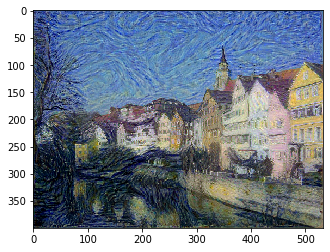

반복 횟수: 18
현재 손실 값: 36614220.0
저장 이미지:  style_transfer_result_at_iteration_18.png
18 번째 반복 완료: 4s


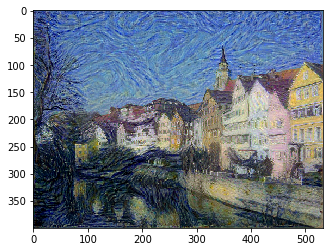

반복 횟수: 19
현재 손실 값: 35392904.0
저장 이미지:  style_transfer_result_at_iteration_19.png
19 번째 반복 완료: 4s


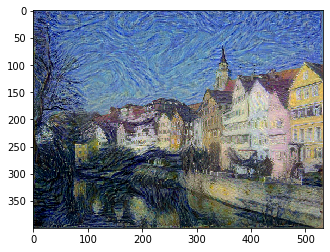

In [16]:
from scipy.optimize import fmin_l_bfgs_b
import time
import matplotlib.pyplot as plt

# 콘텐츠 이미지
print("콘텐츠 이미지")
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
print("스타일 이미지")
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()
plt.show()

print("생성 이미지")
result_prefix = 'style_transfer_result'
iterations = 20

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))
    # 생성된 이미지
    plt.imshow(img)
    plt.show()

## 생성된 이미지


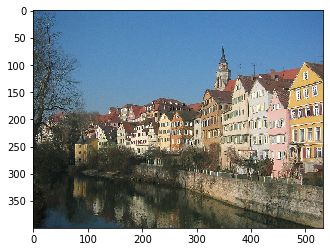

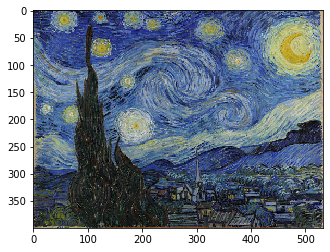

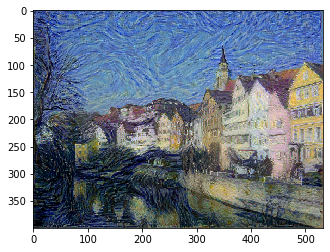

In [13]:
import matplotlib.pyplot as plt

# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()
